In [1]:
#Loading the dataset
import pandas as pd
data = pd.read_excel('Amazon_reviews.xlsx')

In [2]:
#Importing libraries 
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
import itertools
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from textblob import TextBlob
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score



In [3]:
#checking the data classes
data.head()
data['intent'].value_counts()


product     224
seller       60
delivery     36
Name: intent, dtype: int64

#We can see data is imbalanced, will do sampling to balance the data. To inspect this type of data we will check F score 

In [4]:
# Taking independent and dependent variables, x and y from data
x= data['reviews']
y= data['intent']
print(len(x))


320


#we will remove the junks from text data using regex
#we will correct spellings of reviews from Textblob library
#we will then remove stopwords from text so that words required will create impact 
#we will do stemming so that same form of verbs will be present

In [5]:
#Preprocessing the data
ps = PorterStemmer()
corpus = []
data['reviews'] =data['reviews'].apply(lambda x: str(TextBlob(x).correct()))
for i in range(0, len(data)):
    review = re.sub('[^a-zA-Z]', ' ', data['reviews'][i])
    review = review.lower()
    review = review.split()
    
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)

In [6]:
corpus[1]

'low light perform camera outstand'

In [7]:
#checking for nan values in text
print(len(data))
df=data.dropna()
print(len(df))


320
320


In [8]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer

In [55]:
# for text data we will always convert into vectors first which will be passed to model.
tfidf_v=TfidfVectorizer(max_features=50,ngram_range=(1,3))
X=tfidf_v.fit_transform(corpus).toarray()
# performing over sampling to our imbalanced data
from imblearn.over_sampling import SMOTE
sm = SMOTE( random_state =0)
x_samp,y_samp = sm.fit_resample(X,y)
print(len(x_samp))
print(len(y_samp))


672
672


In [56]:
x_samp[1]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.65347667,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.75694666, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

In [57]:
y_samp.value_counts()
# now we can see all classes are balanced.

product     224
seller      224
delivery    224
Name: intent, dtype: int64

In [58]:
X.shape

(320, 50)

In [59]:
# will check results with both normal data and sampled data
#splitting into train and test with validation size 20 %
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
#using sampling
X_train_samp, X_test_samp, y_train_samp, y_test_samp = train_test_split(x_samp, y_samp, test_size=0.2, random_state=0)


In [60]:
tfidf_v.get_feature_names()[:7]

['also', 'amazon', 'ask', 'back', 'batteri', 'batteri life', 'best']

In [61]:
#we can analyze the features by creating dataframe for visvalization
count_df = pd.DataFrame(X_train, columns=tfidf_v.get_feature_names())
count_df_samp = pd.DataFrame(X_train_samp, columns=tfidf_v.get_feature_names())

In [62]:
#function to print and plot confusion matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [63]:
#we can use classification model over tfidf vectors to categorize in which class review belongs
from sklearn.naive_bayes import MultinomialNB
classifier=MultinomialNB()

Using Naive Bayes Multinomial NB model with over sampling
Confusion matrix, without normalization
accuracy:   0.828
precision_score:   0.790
recall_score:   0.609
f1_score:   0.643


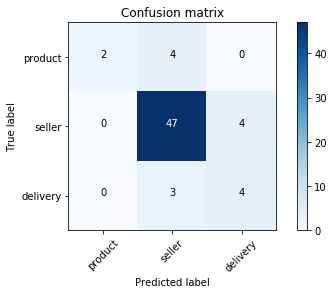

In [64]:
print("Using Naive Bayes Multinomial NB model with over sampling")
classifier.fit(X_train, y_train)
pred = classifier.predict(X_test)
score = metrics.accuracy_score(y_test, pred)
cm = metrics.confusion_matrix(y_test, pred)
plot_confusion_matrix(cm, classes=['product','seller','delivery'])
print("accuracy:   %0.3f" % score)
print("precision_score:   %0.3f" % precision_score(y_test, pred, average="macro"))
print("recall_score:   %0.3f" % recall_score(y_test, pred, average="macro"))
print("f1_score:   %0.3f" % f1_score(y_test, pred, average="macro"))

Using Naive Bayes Multinomial NB model with over sampling
Confusion matrix, without normalization
accuracy with over sampling:   0.822
precision_score:   0.835
recall_score:   0.822
f1_score:   0.824


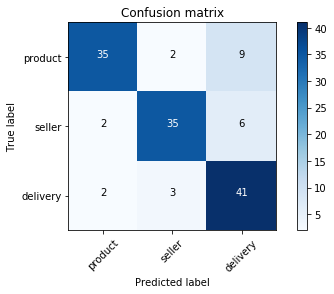

In [65]:
#with sampling
print("Using Naive Bayes Multinomial NB model with over sampling")
classifier.fit(X_train_samp, y_train_samp)
pred = classifier.predict(X_test_samp)
score = metrics.accuracy_score(y_test_samp, pred)

cm_samp = metrics.confusion_matrix(y_test_samp, pred)
#print(cm_samp)
plot_confusion_matrix(cm_samp, classes=['product','seller','delivery'])
print("accuracy with over sampling:   %0.3f" % score)
print("precision_score:   %0.3f" % precision_score(y_test_samp, pred, average="macro"))
print("recall_score:   %0.3f" % recall_score(y_test_samp, pred, average="macro"))
print("f1_score:   %0.3f" % f1_score(y_test_samp, pred, average="macro"))


Using Random Forest model with over sampling
Confusion matrix, without normalization
accuracy with over sampling:   0.822
precision_score:   0.835
recall_score:   0.822
f1_score:   0.824


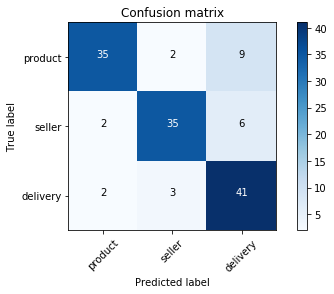

In [66]:
print("Using Random Forest model with over sampling")
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()
clf.fit(X_train_samp, y_train_samp)
pred = classifier.predict(X_test_samp)
score = metrics.accuracy_score(y_test_samp, pred)

cm_samp = metrics.confusion_matrix(y_test_samp, pred)
#print(cm_samp)
plot_confusion_matrix(cm_samp, classes=['product','seller','delivery'])
print("accuracy with over sampling:   %0.3f" % score)
print("precision_score:   %0.3f" % precision_score(y_test_samp, pred, average="macro"))
print("recall_score:   %0.3f" % recall_score(y_test_samp, pred, average="macro"))
print("f1_score:   %0.3f" % f1_score(y_test_samp, pred, average="macro"))

# Classification using LSTM

In [67]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

In [68]:

voc_size=5000

In [93]:
### Dataset Preprocessing
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()
corpus = []
data['reviews'] =data['reviews'].apply(lambda x: str(TextBlob(x).correct()))
print(len(data))
for i in range(0, len(data)):
    review = re.sub('[^a-zA-Z]', ' ', data['reviews'][i])
    review = review.lower()
    review = review.split()
    
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)

320


In [94]:
#we will provide each words with unique id from vocab size 
onehot_repr=[one_hot(words,voc_size)for words in corpus] 
onehot_repr

[[1766, 2272, 3076, 1594],
 [2377, 1426, 255, 4456, 3458],
 [2272, 2155, 3078, 1316, 1766],
 [1533, 1766, 269, 3677],
 [1925,
  783,
  135,
  568,
  2126,
  255,
  4450,
  2039,
  4654,
  2303,
  4737,
  4456,
  1672,
  520,
  4895,
  4605,
  412,
  4327,
  2200,
  1099,
  451,
  2892,
  638,
  4409,
  4954,
  33,
  3508,
  4723,
  2345,
  581,
  1759,
  2714,
  2509,
  3299,
  1331,
  185,
  3974,
  2838,
  2871,
  255,
  1319,
  451,
  3775,
  3078,
  4965,
  135,
  2303,
  4456,
  4737,
  4456,
  1672,
  520,
  4895,
  801,
  2936,
  2456,
  241,
  2509],
 [1533, 3782, 241, 3176],
 [3142, 3625, 3157],
 [520, 2936, 294, 37, 801, 2936, 4047, 2936, 801, 2366, 520, 4877],
 [135, 3076],
 [141, 433, 3968, 1574, 2016],
 [3796, 4478],
 [3890,
  4456,
  4605,
  2984,
  2120,
  4877,
  3623,
  3232,
  3752,
  2730,
  4105,
  1810,
  141,
  433,
  37],
 [3155, 3179, 2874, 3780, 4406, 2874, 2868, 3437, 4911, 4456, 37, 135, 568],
 [2037, 2509, 1672, 3766, 433, 37, 4130, 2494, 1528, 4878],
 [4456

In [95]:
#then to make the sentence size equal we use padding
sent_length=20
embedded_docs=pad_sequences(onehot_repr,padding='pre',maxlen=sent_length)
print(embedded_docs[0])
print("length of embedding docs",len(embedded_docs))
print("lenght of y",(y.shape))

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0 1766 2272 3076 1594]
length of embedding docs 320
lenght of y (320,)


In [110]:
#sampling the data
from imblearn.over_sampling import SMOTE
sm = SMOTE( random_state =0)
x_samp,y_samp = sm.fit_resample(embedded_docs,y)
print(len(x_samp))
print(len(y_samp))

672
672


In [111]:
#we will then encode y variable using to categorical 
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
encoder = LabelEncoder()
encoder.fit(y_samp)
encoded_Y = encoder.transform(y_samp)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_Y)


In [159]:
## Creating model
embedding_vector_features=40
model=Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model.add(LSTM(100))
model.add(Dense(8,activation='relu'))

model.add(Dense(3,activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 20, 40)            200000    
_________________________________________________________________
lstm_12 (LSTM)               (None, 100)               56400     
_________________________________________________________________
dense_22 (Dense)             (None, 8)                 808       
_________________________________________________________________
dense_23 (Dense)             (None, 3)                 27        
Total params: 257,235
Trainable params: 257,235
Non-trainable params: 0
_________________________________________________________________
None


In [160]:
x_samp.shape,dummy_y.shape

((672, 20), (672, 3))

In [161]:
#splitting train test

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_samp, dummy_y, test_size=0.2, random_state=42)

In [162]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=64)

Train on 537 samples, validate on 135 samples
Epoch 1/10
537/537 [==============================] - 3s 7ms/sample - loss: 1.0981 - acc: 0.3445 - val_loss: 1.0955 - val_acc: 0.3037
Epoch 2/10
537/537 [==============================] - 1s 1ms/sample - loss: 1.0908 - acc: 0.4246 - val_loss: 1.0847 - val_acc: 0.2889
Epoch 3/10
537/537 [==============================] - 1s 945us/sample - loss: 1.0618 - acc: 0.5363 - val_loss: 1.0803 - val_acc: 0.4444
Epoch 4/10
537/537 [==============================] - 1s 931us/sample - loss: 1.0138 - acc: 0.6406 - val_loss: 1.0442 - val_acc: 0.5037
Epoch 5/10
537/537 [==============================] - 0s 930us/sample - loss: 0.9340 - acc: 0.7430 - val_loss: 0.9762 - val_acc: 0.4815
Epoch 6/10
537/537 [==============================] - 1s 955us/sample - loss: 0.8269 - acc: 0.7467 - val_loss: 1.5594 - val_acc: 0.4148
Epoch 7/10
537/537 [==============================] - 1s 958us/sample - loss: 0.7984 - acc: 0.7691 - val_loss: 1.1588 - val_acc: 0.3926
Epoch 

In [163]:
score = model.evaluate( X_test, y_test)

135/135 [==============================] - 0s 356us/sample - loss: 0.8034 - acc: 0.6222


In [164]:
model.metrics_names

['loss', 'acc']

In [165]:
score

[0.8034367526019061, 0.62222224]

## Using Birectional LSTM

In [81]:
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dropout

In [82]:
voc_size=5000

In [190]:
embedding_vector_features=40
model1=Sequential()
model1.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model1.add(Bidirectional(LSTM(100)))
model1.add(Dropout(0.3))
model1.add(Dense(8,activation='relu'))
model1.add(Dropout(0.5))
model1.add(Dense(3,activation='softmax'))
model1.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model1.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, 20, 40)            200000    
_________________________________________________________________
bidirectional_5 (Bidirection (None, 200)               112800    
_________________________________________________________________
dropout_15 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_30 (Dense)             (None, 8)                 1608      
_________________________________________________________________
dropout_16 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_31 (Dense)             (None, 3)                 27        
Total params: 314,435
Trainable params: 314,435
Non-trainable params: 0
_________________________________________________________________
None

In [191]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_samp, dummy_y, test_size=0.2, random_state=42)

In [199]:
model1.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=30,batch_size=44)

Train on 537 samples, validate on 135 samples
Epoch 1/30
537/537 [==============================] - 1s 3ms/sample - loss: 0.2858 - acc: 0.8175 - val_loss: 1.3947 - val_acc: 0.6296
Epoch 2/30
537/537 [==============================] - 1s 3ms/sample - loss: 0.2645 - acc: 0.8287 - val_loss: 1.5460 - val_acc: 0.6519
Epoch 3/30
537/537 [==============================] - 1s 3ms/sample - loss: 0.2702 - acc: 0.8212 - val_loss: 1.2297 - val_acc: 0.6370
Epoch 4/30
537/537 [==============================] - 1s 3ms/sample - loss: 0.2861 - acc: 0.8268 - val_loss: 1.7298 - val_acc: 0.6148
Epoch 5/30
537/537 [==============================] - 1s 3ms/sample - loss: 0.2845 - acc: 0.7821 - val_loss: 1.4480 - val_acc: 0.6519
Epoch 6/30
537/537 [==============================] - 1s 3ms/sample - loss: 0.2749 - acc: 0.8063 - val_loss: 1.7565 - val_acc: 0.6148
Epoch 7/30
537/537 [==============================] - 1s 3ms/sample - loss: 0.2909 - acc: 0.7784 - val_loss: 1.5901 - val_acc: 0.6148
Epoch 8/30
537/5

In [200]:
score = model1.evaluate( X_test, y_test)

135/135 [==============================] - 0s 533us/sample - loss: 1.8968 - acc: 0.6222


In [201]:
model.metrics_names

['loss', 'acc']

In [202]:
score

[1.8967662078362924, 0.62222224]